In [1241]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image
import random
from tqdm import tqdm

In [1242]:
import numpy as np

class Environment:
    def __init__(self, environment_rows=11, environment_columns=11, ORDER_REWARD=100,
                 TERMINAL_PENALTY=-100, STEP_PENALTY=-1, START=(1,5), reward_locs=[(8,2),(2,7),(5,4),(8,7)]):
        
        self.environment_rows = environment_rows
        self.environment_columns = environment_columns
        self.ORDER_REWARD = ORDER_REWARD
        self.TERMINAL_PENALTY = TERMINAL_PENALTY
        self.STEP_PENALTY = STEP_PENALTY
        self.START = START
        self.reward_locs = reward_locs.copy() # rewards loc is a list, which is mutable, so we need to make a copy
                                                # otherwise, the original list will be changed when we change the copy
        self.reward_locs.append(START)
        self.NUM_ORDERS = len(self.reward_locs)
        self.orders_left = self.NUM_ORDERS        

        # Call the build_environment function to initialize rewards
        self.REWARDS_MAP = self.build_environment(self.reward_locs.copy()) # map of rewards that will not be updated, used for plotting
        self.active_rewrads = self.REWARDS_MAP.copy() # copy of rewards map that will be updated as orders are completed
        

    def build_environment(self, reward_locs):
        # Create a 2D numpy array to hold the rewards for each state.
        rewards = np.full((self.environment_rows, self.environment_columns), self.TERMINAL_PENALTY)

        # Define aisle locations (i.e., white squares) for rows 1 through 9
        aisles = {}
        aisles[0] = []
        aisles[1] = [i for i in range(1, 10)]
        aisles[2] = [1, 5, 9]
        aisles[3] = [1, 5, 9]
        aisles[4] = [i for i in range(1, 10)]
        aisles[5] = [1, 5, 9]
        aisles[6] = [i for i in range(1, 10)]
        aisles[7] = [1, 5, 9]
        aisles[8] = [1, 5, 9]
        aisles[9] = [i for i in range(1, 10)]
        aisles[10] = []

        # Set the rewards for all aisle locations (i.e., white squares)
        for row_index in range(0, 11):
            for column_index in aisles[row_index]:
                rewards[row_index, column_index] = self.STEP_PENALTY

        # Set the reward for the packaging area (i.e., the goal) to ORDER_REWARD
        for loc in reward_locs[:-1]:
            rewards[loc[0], loc[1]] = self.ORDER_REWARD
        
        return rewards

    def reset_active_rewards(self):
        self.active_rewrads = self.REWARDS_MAP.copy()
        self.orders_left = self.NUM_ORDERS    
        
    def is_terminal_state(self, current_row_index, current_column_index):
        if self.active_rewrads[current_row_index, current_column_index] == self.TERMINAL_PENALTY:
            return True
        else:
            return False
    
    def is_order_state(self, current_row_index, current_column_index, alter_rewards=True):
        """Returns True if the current state is an order state, False otherwise
        
        Also removes the order from the active rewards map, and updates the number of orders left
        
        """

        if self.active_rewrads[current_row_index, current_column_index] == self.ORDER_REWARD:
            if alter_rewards:
                self.active_rewrads[current_row_index, current_column_index] = self.STEP_PENALTY
                self.orders_left -= 1
                #print("Order completed! Orders left: ", self.orders_left)
                if self.orders_left == 1:
                    self.active_rewrads[self.START[0], self.START[1]] = self.ORDER_REWARD
                return True
            else:
                return True
        else:
            return False
    
    
    def get_starting_location(self):
        return self.START[0], self.START[1]
        


In [1243]:
#define the shape of the environment (i.e., its states)
environment_rows = 11
environment_columns = 11
ORDER_REWARD = 100
TERMINAL_PENALTY = -100
STEP_PENALTY = -1
START = (1,5)
reward_locs = [(8,2),(2,7),(5,4),(8,7)]


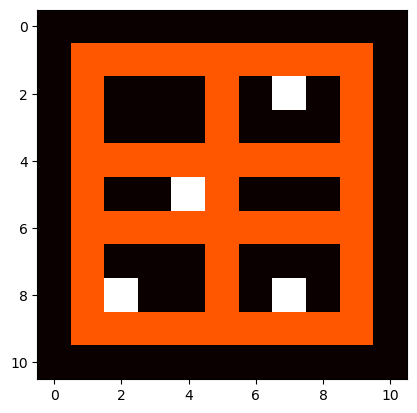

In [1244]:
# Initialize the Environment class
env = Environment(environment_rows, environment_columns, ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs)

# You can access the rewards array using env.rewards
plt.imshow(env.REWARDS_MAP, cmap='hot', interpolation='nearest')


In [1245]:
env.NUM_ORDERS

5

In [1246]:
env.reward_locs


[(8, 2), (2, 7), (5, 4), (8, 7), (1, 5)]

In [1247]:
env.is_terminal_state(1,1)

False

In [1248]:
import numpy as np
from typing import Any, Type
from tqdm import tqdm

class QLearningAgent:
    def __init__(self,environment_rows=11, environment_columns=11,ORDER_REWARD=100, TERMINAL_PENALTY=-100,
                 STEP_PENALTY=-1, START=(1,5), reward_locs=[(8,2),(2,7),(5,4),(8,7)],actions=('up', 'right', 'down', 'left')):
        
        self.env = Environment(environment_rows, environment_columns,ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs.copy())
        # Initialize the Q-values to random numbers between -0.1 and 0.1
        self.q_values = np.random.random((self.env.NUM_ORDERS, environment_rows, environment_columns, 4)) * 2 - 1
        self.q_values = self.q_values / 10
        self.environment_rows = environment_rows
        self.environment_columns = environment_columns
        self.actions = actions


    def get_next_action(self, current_row_index, current_column_index, epsilon, order_number):
        if np.random.random() < epsilon:
            return np.argmax(self.q_values[order_number, current_row_index, current_column_index])
        else:
            return np.random.randint(4)

    def get_next_location(self, current_row_index, current_column_index, action_index):
        new_row_index = current_row_index
        new_column_index = current_column_index
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif self.actions[action_index] == 'right' and current_column_index < self.environment_columns - 1:
            new_column_index += 1
        elif self.actions[action_index] == 'down' and current_row_index < self.environment_rows - 1:
            new_row_index += 1
        elif self.actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        else:
            raise Exception(f"Invalid action {action_index}")
        return new_row_index, new_column_index
    
    def get_shortest_path(self, verbose=True):
        self.env.reset_active_rewards()
        shortest_path = []
        reward_sum = 0
        if self.env.is_terminal_state(self.env.START[0], self.env.START[1]) or self.env.is_order_state(self.env.START[0], self.env.START[1], alter_rewards=False):
            print(f"START: {self.env.START} | Terminal State: {self.env.is_terminal_state(self.env.START[0], self.env.START[1])} | Order State: {self.env.is_order_state(self.env.START[0], self.env.START[1], alter_rewards=False)}")
            print(f"Rwards: {self.env.active_rewrads[self.env.START[0], self.env.START[1]]}")
            raise Exception("The starting location cannot be a terminal state or an order state!")
        current_row_index, current_column_index = self.env.get_starting_location()
        shortest_path.append((current_row_index, current_column_index))
        reward_sum += self.env.active_rewrads[current_row_index, current_column_index]
        while not self.env.is_terminal_state(current_row_index, current_column_index) and self.env.orders_left > 0:
            order_number = self.env.NUM_ORDERS - self.env.orders_left # order number is the number of orders completed so far which is the index of the current order and defines the q_values layer to use
            action_index = self.get_next_action(current_row_index, current_column_index,1.0, order_number)
            current_row_index, current_column_index = self.get_next_location(current_row_index, current_column_index, action_index)
            shortest_path.append((current_row_index, current_column_index))
            reward_sum += self.env.active_rewrads[current_row_index, current_column_index]
            self.env.is_order_state(current_row_index, current_column_index) # this will remove the order from the active rewards map
            
            if len(shortest_path) > 500:
                if verbose:
                    print("Infinite loop! Something is wrong")
                break
        return shortest_path, reward_sum
    
    def fitness_score(self, verbose=False):
        shortest_path, reward_sum = self.get_shortest_path(verbose=verbose)
        return reward_sum
    
    def train(self, num_episodes, epsilon, discount_factor, learning_rate, change_w_gamma=False, verbose = True):
        """ Train the Q-learning agent
        Inputs:
            num_episodes: Number of episodes to use for training
            epsilon: The probability of choosing a random action (between 0 and 1)
            discount_factor: Discount factor for future rewards
            learning_rate: The step size to use for updating the Q-values
            change_w_gamma: If True, the learning rate and epsilon will change with gamma throughout training (default False)
        returns:
            episode_rewards_list: List containing the rewards obtained in each episode during training
        """
        self.env.reset_active_rewards()
        gamma = 1-(1 / (num_episodes/2))
        progress_bar = tqdm(range(num_episodes), desc="Training Progress", unit="Episode", disable=not verbose)
        zero_order_hit_count = 0
        one_order_hit_count = 0
        episode_rewards_list = []
        for episode in progress_bar:
            self.env.reset_active_rewards()
            episode_rewards_sum = 0
            row_index, column_index = self.env.get_starting_location()
            
            while not self.env.is_terminal_state(row_index, column_index) and self.env.orders_left > 0:
                order_number = self.env.NUM_ORDERS - self.env.orders_left
                action_index = self.get_next_action(row_index, column_index,epsilon, order_number=order_number)
                
                old_row_index, old_column_index = row_index, column_index # store the old row and column indexes
                row_index, column_index = self.get_next_location(row_index, column_index, action_index)
                
                reward = self.env.active_rewrads[row_index, column_index]
                episode_rewards_sum += reward
                
                old_q_value = self.q_values[order_number, old_row_index, old_column_index, action_index]
                temporal_difference = reward + (discount_factor * np.max(self.q_values[order_number, row_index, column_index])) - old_q_value
                new_q_value = old_q_value + (learning_rate * temporal_difference)
                self.q_values[order_number, old_row_index, old_column_index, action_index] = new_q_value
                
                if self.env.is_order_state(row_index, column_index):
                    if self.env.orders_left == 0:
                        zero_order_hit_count += 1
                    elif self.env.orders_left == 1:
                        one_order_hit_count += 1
                
            episode_rewards_list.append(episode_rewards_sum)
            
            if change_w_gamma:
                learning_rate = max(learning_rate * gamma, 0.01)
                epsilon = min(epsilon * (2-gamma), 0.9)

            progress_bar.set_postfix({"Ord left": self.env.orders_left, "lr": learning_rate, "Eps": epsilon,
                                      "0 Order":zero_order_hit_count, "1 Order":one_order_hit_count})
        
        progress_bar.close()
        return episode_rewards_list
            
        



In [1249]:
agent = QLearningAgent(environment_rows, environment_columns, ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs)
agent.q_values.shape

(5, 11, 11, 4)

In [1250]:
reward_per_episode_list = agent.train(num_episodes=500, epsilon=0.9, discount_factor=0.9, learning_rate=0.9, verbose=True)

Training Progress: 100%|██████████| 500/500 [00:00<00:00, 1346.95Episode/s, Ord left=5, lr=0.9, Eps=0.9, 0 Order=0, 1 Order=50]


In [1251]:
agent.fitness_score()

-97

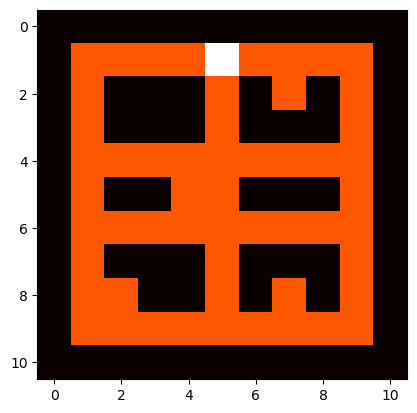

In [1252]:
plt.imshow(agent.env.active_rewrads, cmap='hot', interpolation='nearest')

In [1253]:
agent.env.ORDER_REWARD

100

In [1254]:
shortest_path = agent.get_shortest_path()

Infinite loop! Something is wrong


In [1255]:
print("Path: ",shortest_path[0], "\nRewardSum: ", shortest_path[1])

Path:  [(1, 5), (1, 6), (1, 7), (2, 7), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (4, 5), (4, 4), (5, 4), (6, 4), (6, 3), (6, 2), (6, 1), (7, 1), (8, 1), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (8, 7), (9, 7), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), (8, 2), (9, 2), 

In [1256]:
class GeneticTraining:
    def __init__(self, population=10, num_episodes=1000, epsilon=0.9, discount_factor=0.9, learning_rate=0.1):
        self.population = population
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.agents = [QLearningAgent() for _ in range(population)]
        self.agent_q_table_shape = self.agents[0].q_values.shape
        self.best_agent = None
        self.best_agent_reward = 0
        self.best_agent_index = None
        self.best_agent_shortest_path = None
    
    def agents_fitness_score(self, agents):
        fitness_list = [agent.fitness_score() for agent in agents]
        return fitness_list.copy()
    
    def selection(self, agents):
        """commonly known as roulette wheel selection or fitness-proportionate selection
        in a genetic algorithm. It is a way to select individuals from a population with
        a probability that is proportional to their fitness scores."""
        fitness_list = self.agents_fitness_score(agents)
        fitness_array = np.array(fitness_list, dtype=np.float64)
        if np.min(fitness_array) < 0: # to avoid negative fitness values, which consequently will cause negative probabilities.
            fitness_array -= (np.min(fitness_array) * 2)
            
        if np.sum(fitness_array) == 0:
            fitness_array += 0.001
        normalized_probabilities = fitness_array / (np.sum(fitness_array)) # add a small value to avoid zero probabilities
        parents = np.random.choice(agents, size=2, replace=False, p=normalized_probabilities)
        return parents
    
    def crossover(self, parents)-> QLearningAgent:
        child = QLearningAgent()
        crossover_point = np.random.randint(2, size = self.agent_q_table_shape[:-1])
        crossover_point = np.stack([crossover_point] * self.agent_q_table_shape[-1], axis=-1)
        child_q_values = np.where(crossover_point == 1, parents[0].q_values, parents[1].q_values)
        child.q_values = child_q_values
        return child
    
    def mutation(self, child: Type[QLearningAgent], mutation_prob=0.1)-> QLearningAgent:
        mutation_point = np.random.choice([0,1], size = self.agent_q_table_shape[:-1], p=[1-mutation_prob, mutation_prob])
        mutation_point = np.stack([mutation_point] * self.agent_q_table_shape[-1], axis=-1)
        
        max_gene_value = np.max(child.q_values)
        min_gene_value = np.min(child.q_values)
        
        print(f"max_gene_value: {max_gene_value} | min_gene_value: {min_gene_value}")
        
        mutation_value = np.random.uniform(low=min_gene_value, high=max_gene_value, size=self.agent_q_table_shape)
        child.q_values = np.where(mutation_point == 1, mutation_value, child)
        return child
    
    def genetic_algorithm(self, agents_list, parents_to_keep_ratio=0.5, mutation_prob=0.1):
        agents_list = sorted(agents_list.copy(), key=lambda agent: agent.fitness_score(), reverse=True)
        num_parents_to_keep = int(len(agents_list) * parents_to_keep_ratio)
        num_childs_to_create = len(agents_list) - num_parents_to_keep
        childs_list = []
        for _ in range(num_childs_to_create):
            parents = self.selection(agents_list)
            child = self.crossover(parents)
            # child = self.mutation(child, mutation_prob)
            childs_list.append(child)
            
        agents_list = agents_list[:num_parents_to_keep] + childs_list
        
        return agents_list
        
        
        
        
    
    
    def train(self, episodes = 500, q_learning_episodes = 10):
        if episodes % q_learning_episodes != 0:
            raise Exception("episodes must be divisible by q_learning_step")
        # call the .tarin() method of each agent for q_learning_step times
        steps = episodes // q_learning_episodes
        progress_bar = tqdm(range(steps), desc="Training Progress", unit="Step")
        for step in progress_bar:
            for agent in self.agents:
                agent.train(num_episodes=q_learning_episodes, epsilon=self.epsilon,
                            discount_factor=self.discount_factor, learning_rate=self.learning_rate, verbose=False)
                
            self.agents = self.genetic_algorithm(self.agents)
            
            progress_bar.set_postfix({"Best Reward": self.agents[0].fitness_score(verbose=False)})
        

        

In [1257]:
class test:
    def __init__(self, lst=[1,2,3]):
        self.lst = lst.copy()
    def change_list(self):
        self.lst[0] = 5
        
list_of_lists = [[1,2,3],[4,5,6],[7,8,9]]
t1 = test(list_of_lists[0])
t2 = test(list_of_lists[1])
t3 = test(list_of_lists[2])
for t in [t1,t2,t3]:
    t.change_list()
    print(t.lst)
t1.lst

[5, 2, 3]
[5, 5, 6]
[5, 8, 9]


[5, 2, 3]

In [1258]:
gt = GeneticTraining()
gt.train()

Training Progress: 100%|██████████| 50/50 [00:04<00:00, 10.95Step/s, Best Reward=-97] 


In [1268]:
gt.agents[8].fitness_score()

-97

In [1260]:
# child_test =(gt.crossover(gt.selection(gt.agents)))
# child_test.train(num_episodes=100, epsilon=0.9, discount_factor=0.9, learning_rate=0.9)

In [1261]:
gt.genetic_algorithm(gt.agents)